In [1]:
from data import generate_dataframe

df = generate_dataframe()

Loading data from: ['AMAZON_FASHION_5.json']

filename             samples
AMAZON_FASHION_5     3176   

Data loaded, 3176 total samples.


In [2]:
from preprocessing import preprocess_samples
from utils import get_product_reviews

raw_corpus_samples = list(filter(lambda x: isinstance(x, str), df['reviewText']))
corpus_samples = preprocess_samples(raw_corpus_samples)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/and04144/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/and04144/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/and04144/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
3160it [00:00, 1220891.73it/s]
3160it [00:00, 133885.56it/s]
0it [00:00, ?it/s]

Applying lowercase
Applying remove_punctuation
Applying lemmatize


3160it [00:08, 353.10it/s]


In [3]:
product_id = 'B009MA34NY'
raw_product_samples = get_product_reviews(df, product_id)
product_samples = preprocess_samples(raw_product_samples)

375it [00:00, 888121.96it/s]
375it [00:00, 146340.16it/s]
42it [00:00, 419.74it/s]

Applying lowercase
Applying remove_punctuation
Applying lemmatize


375it [00:00, 408.58it/s]


In [4]:
import n_grams
bigrams = n_grams.get_bigrams(product_samples, 10, 6)
trigrams = n_grams.get_trigrams(product_samples, 2, 17)
product_samples = n_grams.replace_n_grams(product_samples, bigrams, trigrams)

print(bigrams[:10])
print(trigrams[:10])

['light weight', 'arch support']
["women's flex supreme", 'flex supreme tr', 'cardio dance class']


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/and04144/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import evaluation_metrics as em
freqs = em.get_word_freqs(product_samples)
bi_freqs = em.get_bi_freqs(product_samples)

100%|██████████| 375/375 [00:32<00:00, 11.40it/s]


In [6]:
from nltk import word_tokenize
import train
tf_vectorizer = train.get_tf_vectorizer()
tf_vectorizer.set_params(tokenizer=word_tokenize)

Loading pretrained vectorizer...


/home/and04144/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.1.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


CountVectorizer(max_df=0.01, max_features=1000, min_df=2, stop_words='english',
                tokenizer=<function word_tokenize at 0x7f78aa06b3a0>)

In [7]:
product_documents = tf_vectorizer.fit_transform(product_samples)

In [8]:
import train
# Compute topic coherence
n_components = range(1,10)
coherences = []
num_docs = len(product_samples)

for num in n_components:
  lda = train.get_lda(samples=product_documents, n_components=num)
  tf_feature_names = tf_vectorizer.get_feature_names_out()
  coherence = em.avg_umass(lda, tf_feature_names, train.n_top_words, freqs, bi_freqs, num_docs)[1]
  coherences.append(coherence)

for i, c in enumerate(coherences):
  print("Number of topics: ", n_components[i])
  print("Average UMass coherence: ", c)
  print()


Initializing LDA model...
Fitting LDA model...
Initializing LDA model...
Fitting LDA model...
Initializing LDA model...
Fitting LDA model...
Initializing LDA model...
Fitting LDA model...
Initializing LDA model...
Fitting LDA model...
Initializing LDA model...
Fitting LDA model...
Initializing LDA model...
Fitting LDA model...
Initializing LDA model...
Fitting LDA model...
Initializing LDA model...
Fitting LDA model...
Number of topics:  1
Average UMass coherence:  -191.14498719487247

Number of topics:  2
Average UMass coherence:  -188.33278943868487

Number of topics:  3
Average UMass coherence:  -148.5145178312504

Number of topics:  4
Average UMass coherence:  -142.878222571372

Number of topics:  5
Average UMass coherence:  -147.27095229089377

Number of topics:  6
Average UMass coherence:  -145.9684611580712

Number of topics:  7
Average UMass coherence:  -148.66659845011233

Number of topics:  8
Average UMass coherence:  -142.2360195458723

Number of topics:  9
Average UMass coh

Initializing LDA model...
Fitting LDA model...


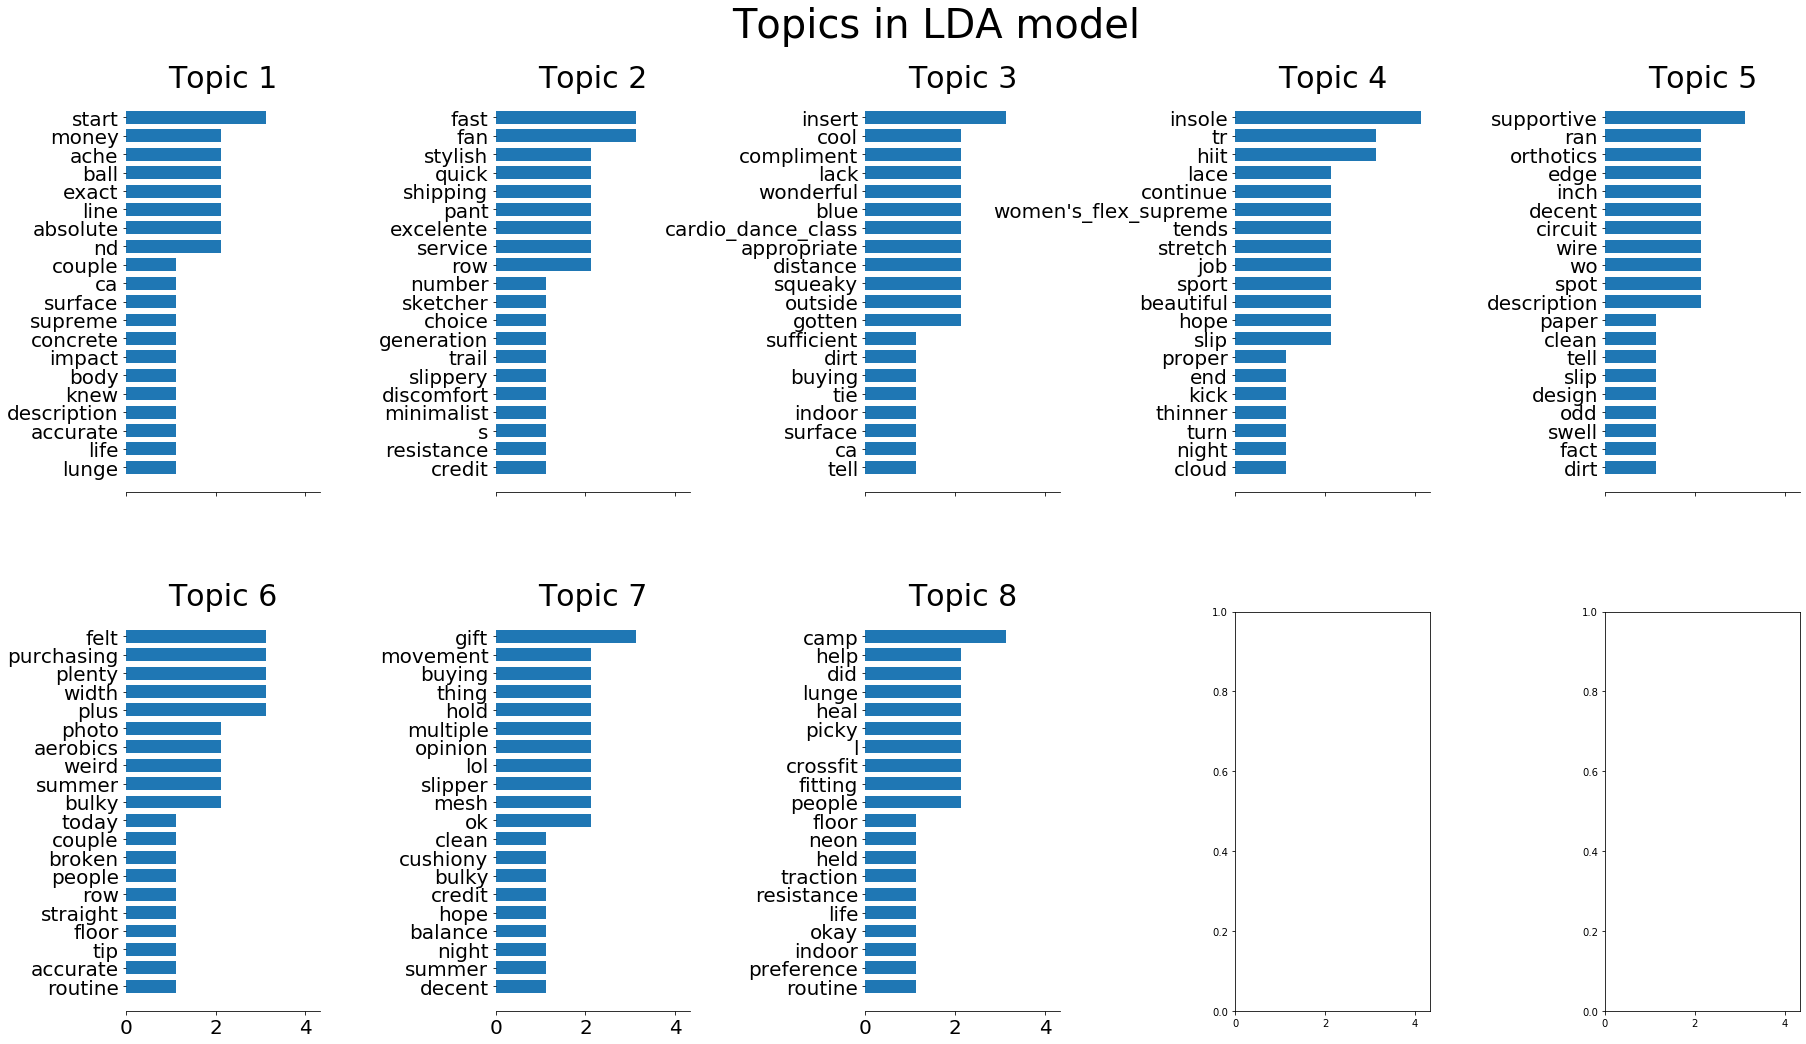

In [9]:
from utils import plot_top_words
coherences = [abs(c) for c in coherences]
n_components = n_components[coherences.index(min(coherences))]

lda = train.get_lda(samples=product_documents, n_components=n_components)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, train.n_top_words, "Topics in LDA model")

# Exploration

In [10]:
# NOTE: Topic numbering in histogram plots and pyLDAvis are not the same
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

topic_data = pyLDAvis.sklearn.prepare(lda, product_documents, tf_vectorizer)
pyLDAvis.display(topic_data)

/home/and04144/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
similarities, x, y = em.jaccard(lda,tf_feature_names,30)
em.print_jaccard(similarities)

Jaccard similarity coefficient between topics:

1 and 2:  0.2
1 and 3:  0.2
1 and 4:  0.1111111111111111
1 and 5:  0.15384615384615385
1 and 6:  0.09090909090909091
1 and 7:  0.1111111111111111
1 and 8:  0.1320754716981132

2 and 3:  0.15384615384615385
2 and 4:  0.15384615384615385
2 and 5:  0.1320754716981132
2 and 6:  0.09090909090909091
2 and 7:  0.15384615384615385
2 and 8:  0.1320754716981132

3 and 4:  0.07142857142857142
3 and 5:  0.2765957446808511
3 and 6:  0.07142857142857142
3 and 7:  0.09090909090909091
3 and 8:  0.1320754716981132

4 and 5:  0.1320754716981132
4 and 6:  0.01694915254237288
4 and 7:  0.07142857142857142
4 and 8:  0.07142857142857142

5 and 6:  0.07142857142857142
5 and 7:  0.1111111111111111
5 and 8:  0.15384615384615385

6 and 7:  0.09090909090909091
6 and 8:  0.1320754716981132

7 and 8:  0.07142857142857142



In [12]:
df['asin'].value_counts()[:20]

B009MA34NY    377
B005AGO4LU    376
B010RRWKT4    376
B0092UF54A    376
B014IBJKNO    375
B0014F7B98    374
B0058YEJ5K    367
B001IKJOLW    365
B000YFSR5G     56
B000YFSR4W     36
B000K2PJ4K     10
B0017LGD34     10
B0017LD0BM     10
B00RLSCLJM      9
B0014F8TIU      8
B00G8Q7JZ4      8
B001LNSY2Q      7
B000KPIHQ4      7
B000V0IBDM      7
B00I0VHS10      4
Name: asin, dtype: int64

In [13]:
tf_vectorizer.stop_words_

{'&',
 "'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 '(',
 '+years',
 ',',
 '-',
 '--',
 '...',
 '....',
 '.....',
 'a-ma-zing',
 'abd',
 'abit',
 'absorption',
 'accommodate',
 'achilles',
 'activity',
 'adjust',
 'adjustment',
 'advice',
 'aerobic',
 'afford',
 'afraid',
 'aide',
 'airport',
 'airy',
 'allows',
 'amazing',
 'amazon',
 'and/or',
 'ankle',
 'arch',
 'arch-support',
 'arch_support',
 'area',
 'arose',
 'artculo',
 'asics',
 'attention',
 'awesome',
 'az',
 'b',
 'back-ups',
 'bag',
 'bailing',
 'band',
 'bandage',
 'barefeet',
 'barefoot',
 'base',
 'beach',
 'beat',
 'bed',
 'bend',
 'bit',
 'blister',
 'blood',
 'bluff',
 'boot',
 'bootcamps',
 'bother',
 'bought',
 'box',
 'boxier',
 'brand',
 'breath',
 'breathe',
 'breathes',
 'bright',
 'broader',
 'btw',
 'build',
 'built',
 'built-in',
 'bulk',
 'bunion',
 'business',
 'c',
 'cable',
 'calf',
 'cam',
 'card',
 'cardio',
 'care',
 'careful',
 'carpet',
 'change',
 'cheap',
 'check',
 'christmas',
 'circulation',
 

In [14]:
from preprocessing import preprocess_sample

raw_reviews = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
processed_sentences, raw_sentences = preprocess_sample(raw_reviews[337], get_raw=True)

processed_sentences

3it [00:00, 18921.67it/s]
3it [00:00, 19753.39it/s]
3it [00:00, 311.84it/s]

Applying lowercase
Applying remove_punctuation
Applying lemmatize


[' and lightweight',
 "need a training shoe that's supportive and ",
 'i like the fit but to size a this style in my size perfect from heel to toe']

In [15]:
for i, sample in enumerate(raw_reviews):
    if len(sample) > 300 and len(sample) < 700:
        print(i,":", sample)

4 : Tried them on in a store before buying online so I knew they'd fit good. Overall I was looking for a durable cross training shoe that would hold up to my rigorous training and these have been great so far. They are really light and comfortable. Most importantly for me they have grips on the bottoms so my feet don't slide out from under me while doing planks, push-ups, etc. Highly satisfied with this purchase.
60 : Glad I read the reviews and ordered a half size too big. These are light weight. I worked out in them last night and had a great work out. They are very comfortable. I would recommend these to anyone. I am a Beach Body Coach and these are now my new favorite shoes to work out in. I feel like I am walking in slippers when I wear these shoes. They are so comfortable. I LOVE them so much. I never buy myself anything nice and for Christmas got an Amazon gift card and used it to buy myself these sneakers and they are so awesome. I really do love them and have been telling all 

In [16]:
feature_names = tf_vectorizer.get_feature_names_out()
topic_words = []
for topic in lda.components_:
    top_features_ind = topic.argsort()[: -10- 1 : -1]
    topic_words.append([feature_names[i] for i in top_features_ind])

In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# TODO: for now compound (a composite score) will suffice. Neutrality (neu) might suggest highly informational content.
for raw, processed in zip(raw_sentences, processed_sentences):
    vs = analyzer.polarity_scores(raw)
    probs = lda.transform(tf_vectorizer.transform([processed]))[0]
    topic = probs.argmax()
    if probs[topic] < 0.2:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, No Topic\n".format(raw, vs['compound'], vs['neu']))
    else:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, Topic {}: {}\n".format(raw, vs['compound'], vs['neu'], topic+1, ", ".join(topic_words[topic])))

ModuleNotFoundError: No module named 'vaderSentiment'

In [18]:
def predict(text):
    raw_sentences = sent_tokenize(text)

    processed_sentences = raw_sentences[:]
    processed_sentences = lowercasing(processed_sentences)
    processed_sentences = punctuation_removal(processed_sentences)
    processed_sentences = lemmatize(processed_sentences)
    

    res = []
    present_topics = set()
    for raw, processed in zip(raw_sentences, processed_sentences):
        vs = analyzer.polarity_scores(raw)
        print("{} \n\t overall: {:.2f} neutral: {:.2f}\n".format(raw, vs['compound'], vs['neu']))


        probs = lda.transform(tf_vectorizer.transform([processed]))[0]
        topic = probs.argmax()
        
        res.append((raw, f"Topic {topic+1} ({round(vs['compound'],2)})"))
        present_topics.add(topic)
        
    topics = {str(i+1): ", ".join(topic_words[i]) for i in sorted(list(present_topics))}
    print(topics)
    return [res, topics]

In [19]:
import numpy as np

sentiment_vals = np.linspace(-1.0, 1.0, num=201)
color_map = {}

colors = {1: "red", 2: "orange", 3: "lime", 4: "pink", 5: "brown", 6: "green", 7: "purple", 8: "blue", 9: "cyan", 10: "yellow"}

for i, color in colors.items():
    color_map.update({f"Topic {i} ({round(val,2)})": color for val in sentiment_vals})

In [20]:
import gradio as gr
from gradio.components import Textbox, HighlightedText, JSON

gr.Interface(fn=predict, 
             inputs=Textbox(placeholder="Enter review here...", lines=5), 
             outputs=[HighlightedText().style(color_map=color_map), JSON()],
             examples=[
        ["Good indoor training shoes for running on treadmill, doing lunges and regular exercises at the gym. These are very flexible, light weight and comfortable. Grip is okay - sticky rubber is used only at the edges of heel and toe areas so I slipped a little when I worked on cable machines, resistance band, etc. on un-carpeted floor.  I would emphasize that if you do lifting as a part of your everyday routine workout I would not recommend them because mine (cushion) lasted only for six months and this is the reason I gave three stars. Other than that, I liked them!"],
        ["I've had these shoes for about a week now and have so far enjoyed using them. Considering the fact that I have wide feet, the shoes are slightly tight. However, it doesn't feel uncomfortable nor does it bothers me as I use them throughout my workouts. I know some people personally like when the shoes are a bit tighter or a bit looser so it's all in personal preference."],
        ["The picture makes the shoe look like it has a \"boxier\" toe rather than the \"pointier\" toe that it actually has. I have wider feet and generally need to buy a size or half size longer to get a comfortable width (in any brand of shoe). I was shooting for a rounder, broader toe design which is more comfortable for me, and I feel that the pictures of this shoe didn't accurately depict what I received, in that one detail. Otherwise, \"the shoe fits\" So I am wearing it."]
    ],
) \
    .launch(share=True)

ModuleNotFoundError: No module named 'gradio'